# Clustering

Steps:
1. Load the data.
2. Perform k-means clustering. Determine the optimal number of clusters using e.g. elbow method.
3. Perform clustering with different clustering methods as implemented in scikit-learn.
4. Now, try clustering with another distance metric (e.g. Cosine, Jaccard, etc.).
Hint: Think whether the default distance metric is appropriate for your data or not.
5. Visualize results using the dimensionality reduction (UMAP or tSNE) techniques with respect to the cluster labels.
6. Compare clustering results. Try to rationalize observed commonalities or differences with respect to clustering methods and distance metrics used.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture as GMM
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### Overview of the dataset

In [2]:
#load data
data = pd.read_csv("hw2_dataset.csv")
data.head(5)

,ID,D_0,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,...,D_1014,D_1015,D_1016,D_1017,D_1018,D_1019,D_1020,D_1021,D_1022,D_1023
0,AAEAMMIUQZAASJ-MRXNPFEDSA-N,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,1,1,1
1,AAEFNWQXBPYXAC-UHFFFAOYSA-N,1,1,1,1,0,1,1,1,0,...,1,0,1,1,1,0,0,1,1,1
2,AAMHSIWFDKXUMZ-UHFFFAOYSA-N,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,0,0,1,1
3,AAPQXEOSVSLLMB-UHFFFAOYSA-N,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,AARXXEHXOBTROW-UHFFFAOYSA-N,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,1,1,1


In [3]:
print("data dimension: ", data.shape)
print("missing values: ",data.isnull().sum().max())
print("categorical variable: ",data.columns[data.dtypes == 'object'])

data dimension:  (969, 1025)
missing values:  0
categorical variable:  Index(['ID'], dtype='object')


For this dataset, only the first column is a categorical variable, and others are numeric variables. To perform clustering, we shoudl first delete the first column.

In [4]:
#drop the ID column
data.drop(columns = "ID",axis=1,inplace=True)

## K-Means Clustering

### Find optimal value of K
#### 1.Elbow Method

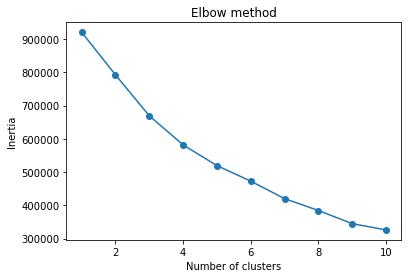

In [5]:
inertias = []
data_scale = StandardScaler().fit_transform(data) # normalizing & centering the features

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_scale)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Given the absence of a clearly defined "elbow" point in the elbow plot above, we can apply the Silhouette Method as an alternative approach for determining the optimal value of k.

#### 2.The Silhouette Method

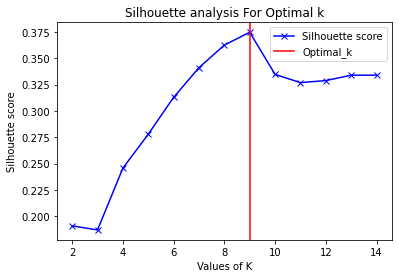

In [6]:
data_scale = StandardScaler().fit_transform(data) #scale the data
num_clusters = list(range(2,15))
silhouette_kmeans = []
optimal_k_kmeans = 0
max_score_kmeans = 0

for i in num_clusters:
  # initialise kmeans
  kmeans = KMeans(n_clusters=i, random_state=123)
  kmeans.fit(data_scale)
  cluster_labels = kmeans.labels_
  # silhouette score
  sil_score = silhouette_score(data_scale, cluster_labels)
  silhouette_kmeans.append(sil_score)
  if (max_score_kmeans < sil_score):
    max_score_kmeans = sil_score
    optimal_k_kmeans = i

plt.plot(num_clusters,silhouette_kmeans,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.axvline(x=optimal_k_kmeans,color="red")
plt.legend(["Silhouette score", "Optimal_k"])
plt.show()


The Silhouette score measures how similar each data point is to its own cluster (cohesion) compared to other clusters (separation). From the plot, the peak represents the number of clusters where the data points are best separated into distinct clusters while maintaining cohesion within each cluster. Thus the red line here represents the optimal k value which is k=9.

In [7]:
k = optimal_k_kmeans
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)

# Get the cluster labels assigned to each data point
cluster_labels_kmeans = kmeans.labels_

## Perform clustering with other methods

K-means is a Centroid-based clustering method. In the following, I will try using Density-based clustering method (DBSCAN) and Distribution-based clustering method (GMM) on this dataset. 

### 1.DBSCAN

Use NearestNeighbors to calculate the average distance between each point and its n_neighbors.

In [8]:
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(data_scale)
distances, indices = neighbors_fit.kneighbors(data_scale)

Sort distance values by ascending value and plot.

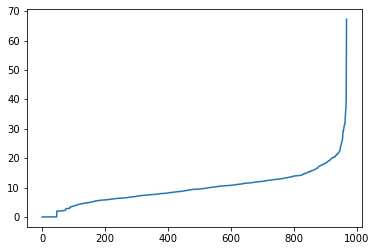

In [9]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

The ideal value for epsilon(eps) will be equal to the distance value at the “crook of the elbow”, or the point of maximum curvature. This point represents the optimization point where diminishing returns are no longer worth the additional cost.

Lets consider eps range 20 to 30 and _min_sample_ range 20 to 30 and iterate over these combinations and get the best silhouette score. 

In [10]:
min_samples = range(20,30)
eps = np.arange(20,30,0.1) # returns array of ranging from 20 to 30 with step of 0.1
output = []

for ms in min_samples:
    for ep in eps:
        labels = DBSCAN(min_samples=ms, eps = ep).fit(data_scale).labels_
        silhouette_dbscan = silhouette_score(data_scale, labels)
        output.append((ms, ep, silhouette_dbscan))

In [11]:
min_samples, eps, score_dbscan = sorted(output, key=lambda x:x[-1])[-1]
print(f"Best silhouette_score: {score_dbscan}")
print(f"min_samples: {min_samples}")
print(f"eps: {eps}")

Best silhouette_score: 0.3668204301815525
min_samples: 29
eps: 28.900000000000126


In [12]:
DBSCAN_model = DBSCAN(min_samples=min_samples, eps = eps).fit(data_scale)
cluster_labels_DBSCAN = DBSCAN_model.labels_
clusters = len(Counter(cluster_labels_DBSCAN))
print(f"Number of clusters: {clusters}")

Number of clusters: 9


### 2.Gaussian Mixture

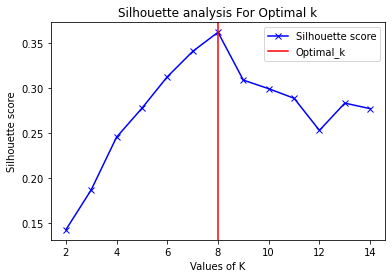

In [13]:
data_scale = StandardScaler().fit_transform(data) #scale the data
num_clusters = list(range(2,15))
silhouette_gmm = []
optimal_k_gmm = 0
max_score_gmm = 0

for i in num_clusters:
  # initialise gmm
  models_gmm = GMM(i, covariance_type='full',random_state=0).fit(data_scale)
  cluster_labels = models_gmm.predict(data_scale)
  # silhouette score
  sil_score = silhouette_score(data_scale, cluster_labels)
  silhouette_gmm.append(sil_score)
  if (max_score_gmm < sil_score):
    max_score_gmm = sil_score
    optimal_k_gmm = i

plt.plot(num_clusters,silhouette_gmm,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.axvline(x=optimal_k_gmm,color="red")
plt.legend(["Silhouette score", "Optimal_k"])
plt.show()


In [14]:
models_gmm = GMM(n_components=8, covariance_type='full',random_state=0).fit(data_scale)
cluster_labels_gmm = models_gmm.predict(data_scale)
clusters = len(Counter(cluster_labels_gmm))
print(f"Number of clusters: {clusters}")

Number of clusters: 8


## Clustering with different distance metrics

### Hierarchical agglomerative clustering

Number of clusters: 14


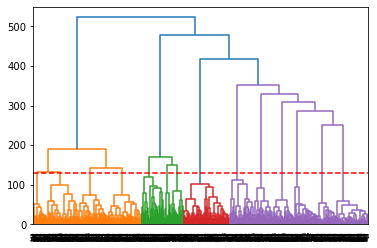

In [77]:
# Plot the hierarchical clustering as a dendrogram.
temp = linkage(data_scale, 'ward', metric='euclidean')
dn = dendrogram(temp)

#cut the dendrogram at the specified threshold and obtain cluster labels.
threshold = 130
cluster_labels = fcluster(temp, threshold, criterion='distance')
clusters = len(Counter(cluster_labels))
print(f"Number of clusters: {clusters}")
plt.axhline(threshold,c='r',linestyle='--')
plt.show()


In [79]:
# generates clusters using agglomerative clustering algorithm
# uses average linkage method with different affinity (metric) values
def agg_clustering(data, num_clusters, metric):
    model_gmm = AgglomerativeClustering(n_clusters=num_clusters,
                                            affinity=metric,
                                            linkage='average')
    clusters_labels = model_gmm.fit_predict(data)
    score = silhouette_score(data,model_gmm.labels_,metric=metric)
    return clusters_labels, score

In [84]:
num_of_cluster = clusters #14
label_euclidean, euclidean_score = agg_clustering(data_scale, num_of_cluster, 'euclidean')
label_manhattan, manhattan_score = agg_clustering(data_scale, num_of_cluster, 'manhattan')
label_cosine, cosine_score = agg_clustering(data_scale, num_of_cluster, 'cosine')
#label_jaccard, jaccard_score = agg_clustering(data_scale, num_of_cluster, 'jaccard')

<BarContainer object of 3 artists>

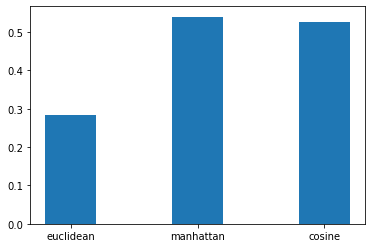

In [85]:
silhouette_scores = {'euclidean': euclidean_score,
                     'manhattan': manhattan_score,
                     'cosine': cosine_score} #,'jaccard': jaccard_score}
plt.bar(list(silhouette_scores.keys()),
        list(silhouette_scores.values()),
        width=0.4)

## Plot the results for comparison
Dimensionality Reduction (t-SNE)

In [19]:
tsne = TSNE(n_components=2) #metric = "jaccard"
data_tsne = tsne.fit_transform(data_scale)

tsne.kl_divergence_

/Users/brittt/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/brittt/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


0.2526211440563202

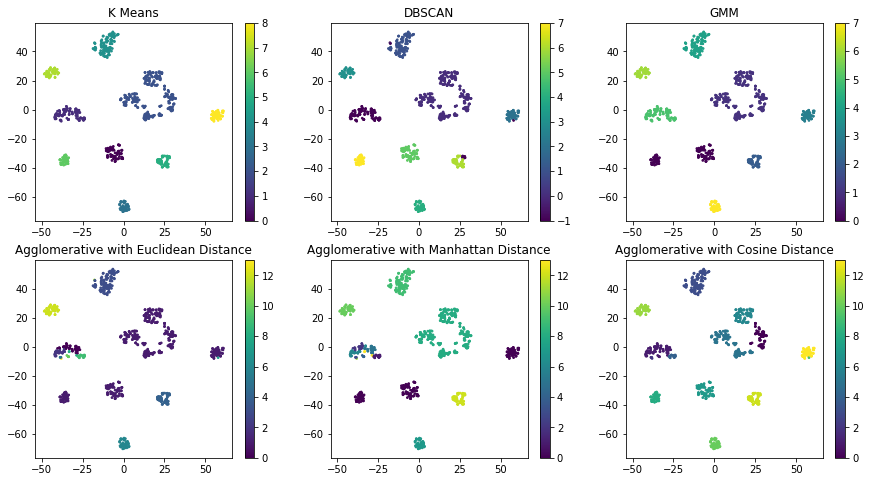

In [87]:
# Initialise the subplot function using number of rows and columns
fig, ax = plt.subplots(2, 3, figsize=(15,8))

#kmeans
scatter_kmeans = ax[0,0].scatter(data_tsne[:, 0], data_tsne[:, 1], c=cluster_labels_kmeans, s=3)
ax[0,0].set_title('K Means')
cbar_kmeans = fig.colorbar(scatter_kmeans, ax=ax[0,0])

#DBSCAN
scatter_dbscan = ax[0,1].scatter(data_tsne[:, 0], data_tsne[:, 1], c=cluster_labels_DBSCAN, s=3)
ax[0,1].set_title('DBSCAN')
cbar_dbscan = fig.colorbar(scatter_dbscan, ax=ax[0,1])

#GMM
scatter_gmm = ax[0,2].scatter(data_tsne[:, 0], data_tsne[:, 1], c=cluster_labels_gmm, s=3)
ax[0,2].set_title('GMM')
cbar_gmm = fig.colorbar(scatter_gmm, ax=ax[0,2])

#Agglomerative - Euclidean Distance
scatter_eul = ax[1,0].scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_euclidean, s=3)
ax[1,0].set_title('Agglomerative with Euclidean Distance')
cbar_gmm = fig.colorbar(scatter_eul, ax=ax[1,0])

#Agglomerative - Manhattan Distance
scatter_mah = ax[1,1].scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_manhattan, s=3)
ax[1,1].set_title('Agglomerative with Manhattan Distance')
cbar_gmm = fig.colorbar(scatter_mah, ax=ax[1,1])

#Agglomerative - Cosine Distance
scatter_cos = ax[1,2].scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_cosine, s=3)
ax[1,2].set_title('Agglomerative with Cosine Distance')
cbar_gmm = fig.colorbar(scatter_cos, ax=ax[1,2])

#Agglomerative - Jaccard Distance
# scatter_jac = ax[1,1].scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_jaccard, s=3)
# ax[1,1].set_title('Agglomerative with Jaccard Distance')
# cbar_gmm = fig.colorbar(scatter_jac, ax=ax[1,1])

<BarContainer object of 6 artists>

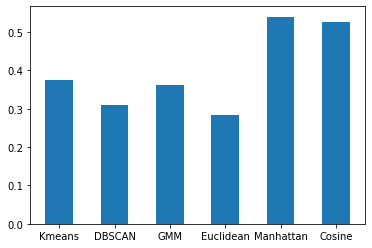

In [88]:
silhouette_scores = {'Kmeans': max_score_kmeans,
                     'DBSCAN': silhouette_dbscan,
                     'GMM': max_score_gmm,
                     'Euclidean': euclidean_score,
                     'Manhattan': manhattan_score,
                     'Cosine': cosine_score}
plt.bar(list(silhouette_scores.keys()),
        list(silhouette_scores.values()),
        width=0.5)

### Results Comparison

Silhouette score is a measure used to evaluate the quality of clusters formed by different clustering algorithms. A higher silhouette score indicates better-defined and more separated clusters.

Based on the scatter plots and the bar chart of each method's silhouette_score, we can notice that Agglomerative with Manhattan and Cosine distance metrics are the top two model. For clustering methods using Euclidean distance metric, Kmeans performs best, followed by GMM and then DBSCAN.

I think these results are mainly due to their inherent characteristics and the nature of the data:

1. K-means assumes that clusters are spherical and equally sized. From the t-SNE plots, we can obesrve that each cluster is almost in a spherical shape and most of them are equally sized. DBSCAN, on the other hand, is designed for datasets with varying densities and irregular cluster shapes, which is not the characteristics of this data.
2. K-means can be used to sparse, high dimensional data, but DBSCAN generally implements poorly for such information because the traditional Euclidean definition of density does not operate well for high dimensional data.
3. As for different metrics, Manhattan distance works the best might be because it calculates the distance between two coordinates in a grid-like path. Thus it is a more effective metric in cases when discrete or binary attributes are present in the dataset. And Cosine similarity measures the cosine of the angle between two vectors, thus for binary values, clustering based on angle can be appropriate. 
4. Euclidean distance is sensitive to the scale of the features and assumes that the features have meaningful magnitudes. In the context of binary data, it cannot effectively capture the dissimilarity between data points. And when features are binary, there are only two possible values (0 or 1), and the magnitude doesn't carry meaningful information. 